In [44]:
from keras.utils import plot_model
from keras.layers import Input, Dense, Flatten, Reshape, Conv2D, UpSampling2D, MaxPooling2D, Concatenate
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.callbacks import Callback
from keras.optimizers import Adam
import random
import glob
import wandb
from wandb.keras import WandbCallback
import subprocess
import os
from PIL import Image
import numpy as np
import cv2
from keras import backend as K
from skimage import io, color

In [115]:
from collections import namedtuple
config = namedtuple('config', ['height', 'width'])
config.height = 256
config.width = 256
config.batch_size=8
config.num_epochs=1
val_dir = 'test'
train_dir = 'train'
img_dir = 'images'

In [8]:
def perceptual_distance(y_true, y_pred):
    rmean = ( y_true[:,:,:,0] + y_pred[:,:,:,0] ) / 2;
    r = y_true[:,:,:,0] - y_pred[:,:,:,0]
    g = y_true[:,:,:,1] - y_pred[:,:,:,1]
    b = y_true[:,:,:,2] - y_pred[:,:,:,2]
    
    return K.mean(K.sqrt((((512+rmean)*r*r)/256) + 4*g*g + (((767-rmean)*b*b)/256)));

In [16]:
from keras.models import load_model
#model_best = load_model('colorizer-applied-dl/wandb/run-20190407_023019-swgz5rs6/model-best.h5', custom_objects={'perceptual_distance': perceptual_distance})

In [44]:
for layer in model.layers:
    print(layer, layer.input_shape)

<keras.layers.core.Reshape object at 0x7f897c677240> (None, 256, 256)
<keras.layers.convolutional.Conv2D object at 0x7f897c677550> (None, 256, 256, 1)
<keras.layers.pooling.MaxPooling2D object at 0x7f897c6775c0> (None, 256, 256, 32)
<keras.layers.convolutional.Conv2D object at 0x7f897c677358> (None, 128, 128, 32)
<keras.layers.pooling.MaxPooling2D object at 0x7f89687f46d8> (None, 128, 128, 32)
<keras.layers.convolutional.Conv2D object at 0x7f89687f4080> (None, 64, 64, 32)
<keras.layers.convolutional.UpSampling2D object at 0x7f8968790cf8> (None, 64, 64, 32)
<keras.layers.convolutional.Conv2D object at 0x7f8968790b70> (None, 128, 128, 32)
<keras.layers.convolutional.UpSampling2D object at 0x7f89687a7588> (None, 128, 128, 32)
<keras.layers.convolutional.Conv2D object at 0x7f89687a72e8> (None, 256, 256, 32)


In [3]:
img = Image.open('/home/ubuntu/colorizer-applied-dl/test/amazing-beautiful-beauty-blue.jpg').resize((config.width, config.height))
color_image= np.expand_dims(np.array(img), axis=0)
bw_image = np.expand_dims(np.array(img.convert('L')), axis=0)

NameError: name 'Image' is not defined

In [ ]:
color_image.shape, bw_image.shape

In [107]:

#model.evaluate(x=bw_image, y=color_image,batch_size=1)



ValueError: Error when checking input: expected input_11 to have 4 dimensions, but got array with shape (1, 256, 256)

In [5]:
plot_model(model, to_file='model.png')

In [101]:
img.shape

NameError: name 'img' is not defined

In [51]:
out = model.predict(x=bw_image)

In [61]:
im = Image.fromarray(out[0].astype('uint8'))

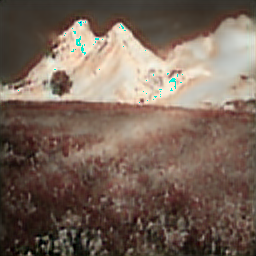

In [62]:
im

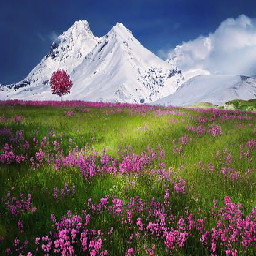

In [63]:
img

### New Model

In [14]:
model = Sequential()
model.add(Reshape((config.height,config.width,1), input_shape=(config.height,config.width)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))
#model.add(UpSampling2D((2, 2)))
#model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))
#model.add(UpSampling2D((2, 2)))
#model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
up_sampling2d_12 (UpSampling (None, 128, 128, 128)     0         
__________

### ResNet50

In [21]:
from keras.applications.resnet50 import ResNet50

In [67]:
img_input = Input(shape=(config.height,config.width,1))
img_conc = Concatenate()([img_input, img_input, img_input])
resnet_model = ResNet50(input_tensor=img_conc, pooling='max', include_top=False)

In [2]:
#resnet_model.summary()

In [73]:
layer_name = 'activation_266'
#intermediate_layer_model = Model(inputs = resnet_model.input, outputs=resnet_model.get_layer(layer_name).output)

In [120]:
resnet_model.layers[76].output

<tf.Tensor 'activation_266/Relu:0' shape=(?, 32, 32, 128) dtype=float32>

In [74]:
intermediate_layer_output = resnet_model.get_layer(layer_name).output

In [82]:
conv2d_output_0 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(intermediate_layer_output)
upsampling_output_0 = UpSampling2D(size=(2,2))(conv2d_output)

In [87]:
conv2d_output_1 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(upsampling_output_0)
upsampling_output_1 = UpSampling2D(size=(2,2))(conv2d_output_1)

In [93]:
print( conv2d_output_0.shape, upsampling_output_0.shape,
       conv2d_output_1.shape, upsampling_output_1.shape,
       conv2d_output_2.shape, upsampling_output_2.shape,
       )

(?, 32, 32, 128) (?, 64, 64, 128) (?, 64, 64, 128) (?, 128, 128, 128) (?, 128, 128, 128) (?, 256, 256, 128)


In [92]:
conv2d_output_2 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(upsampling_output_1)
upsampling_output_2 = UpSampling2D(size=(2,2))(conv2d_output_2)

In [96]:
color_image = Conv2D(filters=3, kernel_size=(3,3),activation='relu', padding='same')(upsampling_output_2)

In [97]:
color_image.shape

TensorShape([Dimension(None), Dimension(256), Dimension(256), Dimension(3)])

In [99]:
model_final = Model(inputs=resnet_model.input, outputs=color_image)

In [110]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_final.compile(optimizer=adam, loss='mse', metrics=[perceptual_distance])

In [111]:
def my_generator(batch_size, img_dir):
    """A generator that returns black and white images and color images"""
    image_filenames = glob.glob(img_dir + "/*")
    counter = 0
    while True:
        bw_images = np.zeros((batch_size, config.width, config.height))
        color_images = np.zeros((batch_size, config.width, config.height, 3))
        random.shuffle(image_filenames) 
        if ((counter+1)*batch_size>=len(image_filenames)):
              counter = 0
        for i in range(batch_size):
              img = Image.open(image_filenames[counter + i]).resize((config.width, config.height))
              color_images[i] = np.array(img)
              bw_images[i] = np.array(img.convert('L'))
        yield (bw_images, color_images)
        counter += batch_size


In [116]:
model.fit_generator( my_generator(config.batch_size, train_dir),
                     steps_per_epoch=2,
                     epochs=config.num_epochs, callbacks=[WandbCallback(data_type='image', predictions=16)],
                     validation_data=(val_bw_images, val_color_images))




Error: You must call wandb.init() before WandbCallback()

In [1]:
Reshape?

Object `Reshape` not found.
